In [2]:
from scipy.stats import ttest_ind
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import re
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import statsmodels.api as sm
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures


In [3]:
home = pd.read_csv('./datasets/train.csv')

In [4]:
home.head()

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice
0,109,533352170,60,RL,NaN,13517,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,3,2010,WD,130500
1,544,531379050,60,RL,43.0,11492,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,4,2009,WD,220000
2,153,535304180,20,RL,68.0,7922,Pave,NaN,Reg,Lvl,...,0,0,NaN,NaN,NaN,0,1,2010,WD,109000
3,318,916386060,60,RL,73.0,9802,Pave,NaN,Reg,Lvl,...,0,0,NaN,NaN,NaN,0,4,2010,WD,174000
4,255,906425045,50,RL,82.0,14235,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,3,2010,WD,138500


In [5]:
home.shape

(2051, 81)

In [6]:
home.columns

Index(['Id', 'PID', 'MS SubClass', 'MS Zoning', 'Lot Frontage', 'Lot Area',
       'Street', 'Alley', 'Lot Shape', 'Land Contour', 'Utilities',
       'Lot Config', 'Land Slope', 'Neighborhood', 'Condition 1',
       'Condition 2', 'Bldg Type', 'House Style', 'Overall Qual',
       'Overall Cond', 'Year Built', 'Year Remod/Add', 'Roof Style',
       'Roof Matl', 'Exterior 1st', 'Exterior 2nd', 'Mas Vnr Type',
       'Mas Vnr Area', 'Exter Qual', 'Exter Cond', 'Foundation', 'Bsmt Qual',
       'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin SF 1',
       'BsmtFin Type 2', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF',
       'Heating', 'Heating QC', 'Central Air', 'Electrical', '1st Flr SF',
       '2nd Flr SF', 'Low Qual Fin SF', 'Gr Liv Area', 'Bsmt Full Bath',
       'Bsmt Half Bath', 'Full Bath', 'Half Bath', 'Bedroom AbvGr',
       'Kitchen AbvGr', 'Kitchen Qual', 'TotRms AbvGrd', 'Functional',
       'Fireplaces', 'Fireplace Qu', 'Garage Type', 'Garage Yr Blt',
       'G

In order to make sorting / calling / organizing easier, I'm going to make all columns lowercase and remove spaces.

In [7]:
home.columns = [col.lower().replace(' ', '_') for col in home.columns]

In [8]:
home.head(1)

,id,pid,ms_subclass,ms_zoning,lot_frontage,lot_area,street,alley,lot_shape,land_contour,...,screen_porch,pool_area,pool_qc,fence,misc_feature,misc_val,mo_sold,yr_sold,sale_type,saleprice
0,109,533352170,60,RL,NaN,13517,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,3,2010,WD,130500


Okay, that looks good!

Now I'd like to check a heatmap of correlation to see what (numerical) columns seem to have the strongest link to sales price.

In [9]:
#https://stackoverflow.com/questions/33104322/auto-adjust-font-size-in-seaborn-heatmap

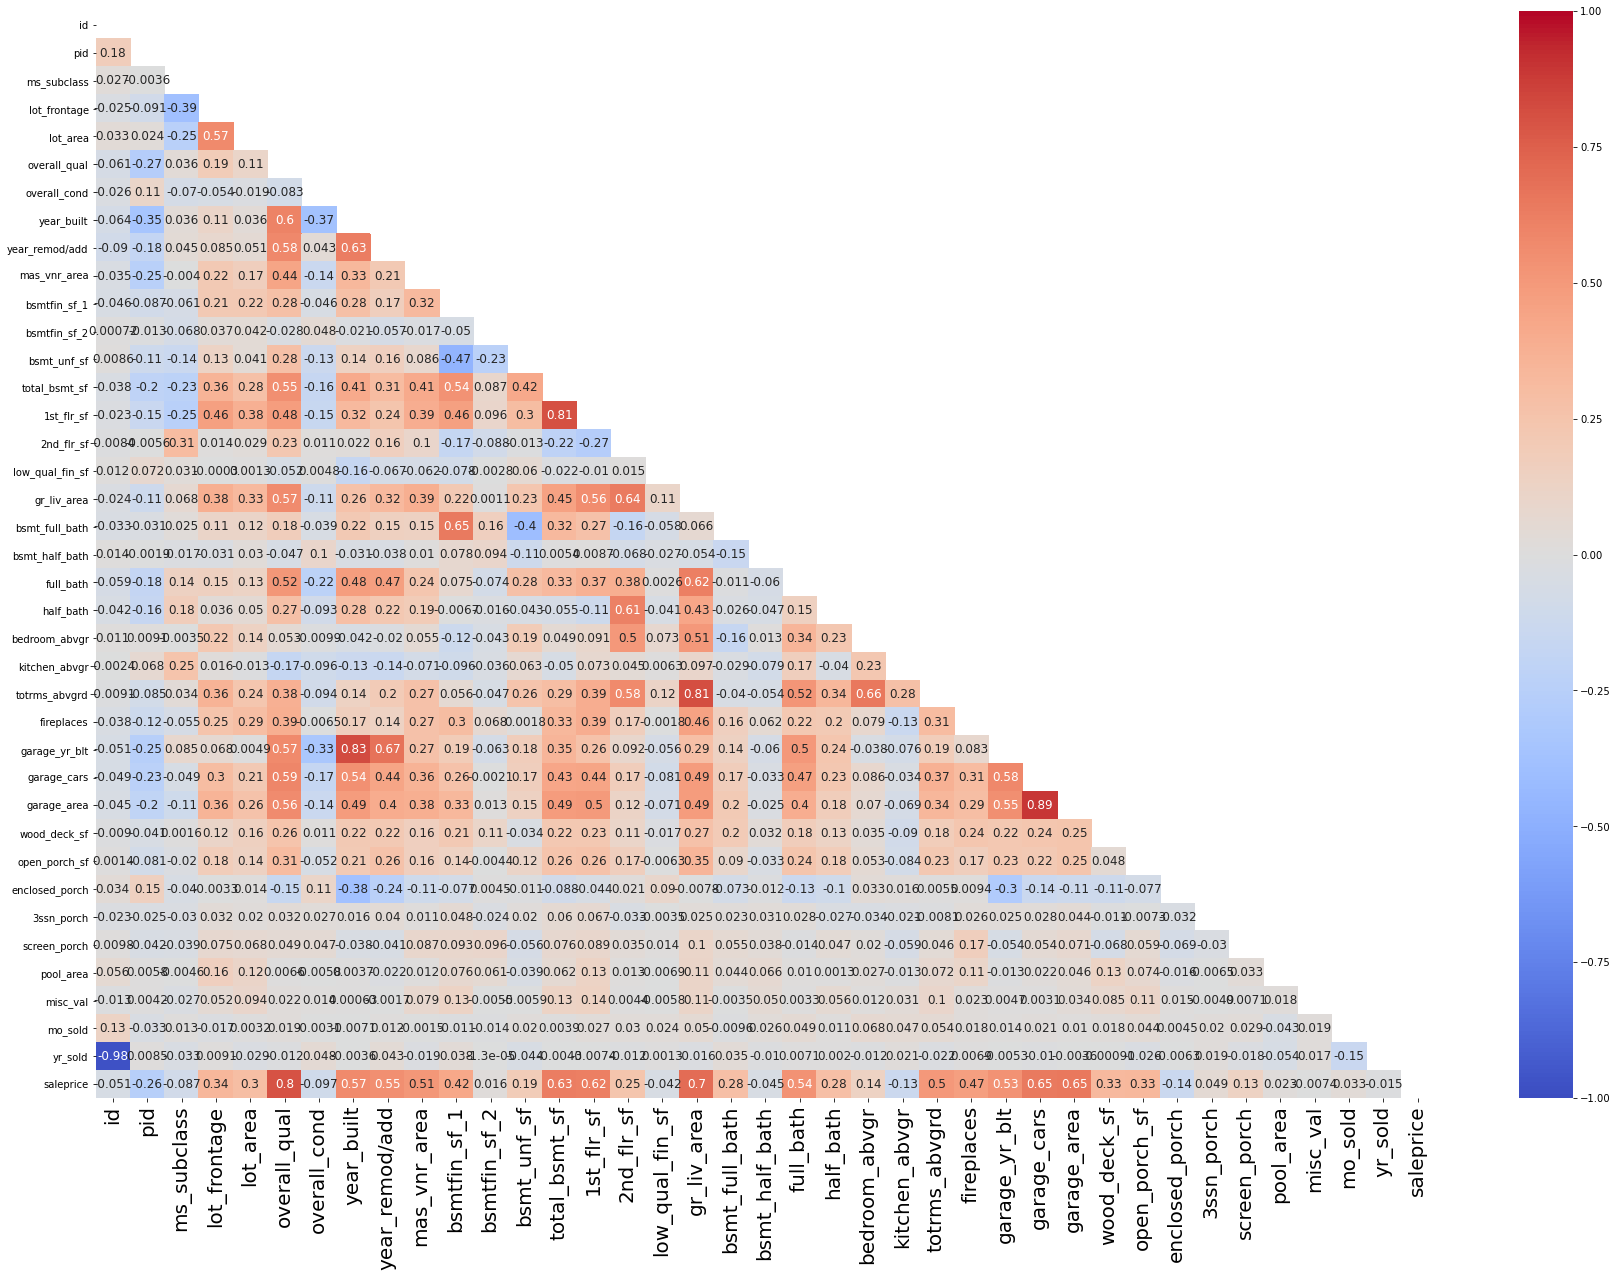

In [10]:
corr = home.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.figure(figsize=(30,20))
#plt.yticks(size=20)
plt.xticks(size=20, rotation=15)
sns.heatmap(home.corr(), mask=mask, annot=True, cmap='coolwarm', vmin=-1, vmax=1, annot_kws={"size":12});

This heatmap suggests correlation (over .5) between saleprice and 10 key categories:  
1. overall_qual
2. year_built
3. year_remod/add
4. total_bsmnt_sf
5. 1st_floor_sf
6. gr_liv_area
7. full_bath
8. garage_yr_blt
9. garage_cars
10. garage_area

-year_built and garage_yr_built are highly correlated (.83) so I probably don't need both. I'll drop garage_yr_blt.  
-garage_cars and garage_area are also highly correlated(.89) so I will drop garage_cars  
-1st_floor_sf and total_bsmnt_sf show correlation (.82) so I'll drop 1st_floor_sf  
-year_built vs year_remod/add?

I'd like to use the remaining categories for "numerical_only" model. I'll also plan to use them in a mixed numerical/categorical submission:
1. overall_qual
2. year_built
3. year_remod/add
4. total_bsmnt_sf

6. gr_liv_area
7. full_bath


10. garage_area

In [11]:
features = ['overall_qual', 'year_built', 'year_remod/add', 'total_bsmt_sf', 'gr_liv_area', 'full_bath', 'garage_area']
#features = ['overall_qual', 'year_built', 'year_remod/add', 'total_bsmt_sf', 'gr_liv_area', 'full_bath', 'garage_yr_blt', 'garage_area']


In [12]:
X = home[features].fillna(0)
y = home['saleprice']

In [13]:
X.isnull().sum()

overall_qual      0
year_built        0
year_remod/add    0
total_bsmt_sf     0
gr_liv_area       0
full_bath         0
garage_area       0
dtype: int64

In [14]:
lr = LinearRegression()

In [15]:
lr.fit(X, y)

LinearRegression()

In [16]:
lr.score(X, y)

0.7891577116047717

In [17]:
pred = lr.predict(X)
metrics.mean_squared_error(y, pred)**.5

36384.774108824015

In [18]:
#accepts df name, test_name, features list, any feature columns that need to be dummified
def make_model(df, test_name, features, dum_cols):
    X = df[features].fillna(0)
    #if you need to get dummies in any categorical columns, it happens here:
    #pd.get_dummies(X_test, columns=dum_cols, drop_first=True)
    y = df['saleprice']
    lr = LinearRegression()
    lr.fit(X, y)
    lr.score(X, y)
    pred = lr.predict(X)
    return f'Your RMSE for test {test_name} is {metrics.mean_squared_error(y, pred)**.5}.'

In [19]:
make_model(home, 'withgarageblt', features, 0)

'Your RMSE for test withgarageblt is 36384.774108824015.'

In [20]:
test = pd.read_csv('datasets/test.csv')

In [21]:
test.columns = [col.lower().replace(' ', '_') for col in test.columns]

In [22]:
sub1 = test[['id']].copy()

In [23]:
sub1

,id
0,2658
1,2718
2,2414
3,1989
4,625
...,...
873,1662
874,1234
875,1373
876,1672


In [24]:
X_test = test[features].fillna(0)

In [25]:
#lr.predict(X_test)

In [26]:
sub1['SalePrice'] = lr.predict(X_test)

In [27]:
sub1 = sub1.rename(columns = {'id' : 'Id'})
sub1['Id'] = [int(n) for n in sub1['Id']]

In [28]:
sub1

,Id,SalePrice
0,2658,167607.913006
1,2718,211076.486169
2,2414,198604.384135
3,1989,127458.173979
4,625,180159.756702
...,...,...
873,1662,194667.018022
874,1234,206440.821610
875,1373,131212.795055
876,1672,103656.807388


In [29]:
#sub1.to_csv('models/mod1.csv', index=False)

In [30]:
#takes 3 arguments, list of feature columns, list of dummy cols, test number, model
def save_model(features, dum_cols, test_num, model): 
    test = pd.read_csv('datasets/test.csv') #read in test file
    test.columns = [col.lower().replace(' ', '_') for col in test.columns] #reformat test columns
    sub['Id'] = test[['id']].copy #put id numbers in empty array
    X_test = test[features].fillna(0) #create X value based on selected features, fill (numerical) nans with 0's
    #if you need to get dummies in any categorical columns, it happens here:
    #pd.get_dummies(X_test, columns=dum_cols, drop_first=True)
    sub['SalePrice'] = model.predict(X_test) #make new df column from predictions
    sub = sub.rename(columns = {'id' : 'Id'}) #rename id column to fit submission model
    sub['Id'] = [int(n) for n in sub['Id']] #make id numbers ints to fit submission model
    sub.to_csv(f'models/mod{test_num}.csv', index=False) #save submission as new csv
    return f"All done, submission {test_num} saved"

In [31]:
# Credit to Devin for the below code
#pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)

This is an updated function I created on the "Training" notebook. I'm returning here to see how my numerical features compare residually.

In [32]:
#accepts df name, test_name, features list, any feature columns that need to be dummified
def make_model(df, test_name, features, dum_cols):
    X = df[features].fillna(0) #will make nan (should only be numerical) values zeroes
    if dum_cols != 0: #if you need to get dummies in any categorical columns, it happens here, otherwise enter '0'
        X = pd.get_dummies(X, columns=dum_cols, drop_first=True)
    y = df['saleprice'] #add target
    lr = LinearRegression()
    lr.fit(X, y)
    print(f'Your R2 score is {lr.score(X, y)}')
    pred = lr.predict(X)
    #pred = [n*1 for n in pred] #manual adjustment of preds if desired
    residuals = y - pred #these are the residuals
    residuals.hist()
    plt.axvline(0, color = 'red')
    plt.show()
    return f'Your RMSE for test {test_name} is {metrics.mean_squared_error(y, pred)**.5}.'

Your R2 score is 0.7891577116047717


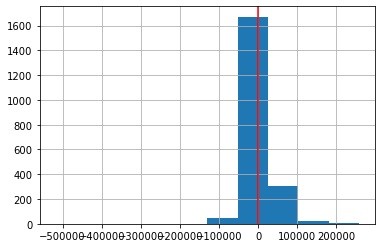

'Your RMSE for test withgarageblt2 is 36384.774108824015.'

In [33]:
make_model(home, 'withgarageblt2', features, 0)

Let's see what adding a few more numerical filters does: ['bsmtfin_sf_1'] has a correlation of .42 based on our heatmap. I'm also going to add mas_vnr_area, totrms_abvgrd, and fireplaces which were close to .5

In [34]:
features = ['overall_qual', 'year_built', 'year_remod/add', 'total_bsmt_sf', 'gr_liv_area', 'full_bath', 'garage_area',
           'mas_vnr_area', 'totrms_abvgrd', 'fireplaces', 'bsmtfin_sf_1']

Your R2 score is 0.8070681502996734


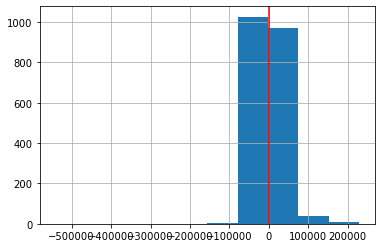

'Your RMSE for test num2 is 34805.09202716528.'

In [35]:
make_model(home, 'num2', features, 0)

That brought our score down a little more. I'll keep those changes on my next full run through.

In [36]:
#from lesson 3.06
home._get_numeric_data().isnull().sum()

id                   0
pid                  0
ms_subclass          0
lot_frontage       330
lot_area             0
overall_qual         0
overall_cond         0
year_built           0
year_remod/add       0
mas_vnr_area        22
bsmtfin_sf_1         1
bsmtfin_sf_2         1
bsmt_unf_sf          1
total_bsmt_sf        1
1st_flr_sf           0
2nd_flr_sf           0
low_qual_fin_sf      0
gr_liv_area          0
bsmt_full_bath       2
bsmt_half_bath       2
full_bath            0
half_bath            0
bedroom_abvgr        0
kitchen_abvgr        0
totrms_abvgrd        0
fireplaces           0
garage_yr_blt      114
garage_cars          1
garage_area          1
wood_deck_sf         0
open_porch_sf        0
enclosed_porch       0
3ssn_porch           0
screen_porch         0
pool_area            0
misc_val             0
mo_sold              0
yr_sold              0
saleprice            0
dtype: int64

I am noticing that mas_vnr_area has 22 null values - I've been flatly making them 0. I wonder if that's hurting my score.

In [37]:
#home.loc[(home['mas_vnr_area']==0) & (home['mas_vnr_type'] == 'None')]
#home.loc[(home['mas_vnr_area']==0) | (home['mas_vnr_type'] == 'None')]
#home.loc[(home['mas_vnr_type'] == 'None')]
#home.groupby('mas_vnr_type')['mas_vnr_area'].mean()
home.loc[home['mas_vnr_area'].isnull()]['mas_vnr_type']

22      NaN
41      NaN
86      NaN
212     NaN
276     NaN
338     NaN
431     NaN
451     NaN
591     NaN
844     NaN
913     NaN
939     NaN
1025    NaN
1244    NaN
1306    NaN
1430    NaN
1434    NaN
1606    NaN
1699    NaN
1815    NaN
1820    NaN
1941    NaN
Name: mas_vnr_type, dtype: object

There are 635 homes listed as "none" for mason veneer type but only 22 are actually "0" for mas_vnr_area. Hmm...

In [38]:
home['mas_vnr_area'].mean()

99.69590931493346

It looks like there are 8 of my 22 "0" values that are not part of the 'None" mas_vnr_type. I'm going to try putting the mean for mas_vnr_area in for the nan values instead of "0"- we'll see if that helps.

In [39]:
#accepts df name, test_name, features list, any feature columns that need to be dummified
def make_model(df, test_name, features, dum_cols):
    X = df[features] #will make nan (should only be numerical) values zeroes
    X['mas_vnr_area'].fillna(df['mas_vnr_area'].mean(), inplace=True)
    X.fillna(0, inplace=True)
    if dum_cols != 0: #if you need to get dummies in any categorical columns, it happens here, otherwise enter '0'
        X = pd.get_dummies(X, columns=dum_cols, drop_first=True)
    y = df['saleprice'] #add target
    lr = LinearRegression()
    lr.fit(X, y)
    print(f'Your R2 score is {lr.score(X, y)}')
    pred = lr.predict(X)
    #pred = [n*1 for n in pred] #manual adjustment of preds if desired
    residuals = y - pred #these are the residuals
    residuals.hist()
    plt.axvline(0, color = 'red')
    plt.show()
    return f'Your RMSE for test {test_name} is {metrics.mean_squared_error(y, pred)**.5}.'

In [40]:
features = ['overall_qual', 'year_built', 'year_remod/add', 'total_bsmt_sf', 'gr_liv_area', 'full_bath', 'garage_area',
           'mas_vnr_area', 'totrms_abvgrd', 'fireplaces', 'bsmtfin_sf_1']

C:\Users\willg\anaconda3\lib\site-packages\pandas\core\generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)
C:\Users\willg\anaconda3\lib\site-packages\pandas\core\frame.py:4147: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


Your R2 score is 0.8071324609911666


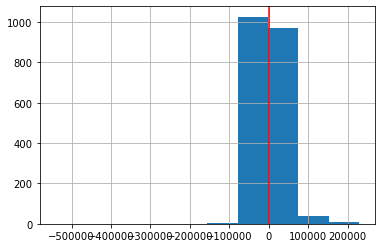

'Your RMSE for test num3_mean is 34799.29068824992.'

In [41]:
make_model(home, 'num3_mean', features, 0)

Okay - time to test some polynomials and/or cross-multiplied columns to see if I can find some new, high correlation.

In [42]:
#from lesson 3.05

In [43]:
features = ['overall_qual', 'year_built', 'year_remod/add', 'total_bsmt_sf', 'gr_liv_area', 'full_bath', 'garage_area',
           'mas_vnr_area', 'totrms_abvgrd', 'fireplaces', 'bsmtfin_sf_1']
X = home[features]
X['mas_vnr_area'].fillna(home['mas_vnr_area'].mean(), inplace=True)
X.fillna(0, inplace=True)

C:\Users\willg\anaconda3\lib\site-packages\pandas\core\generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)
C:\Users\willg\anaconda3\lib\site-packages\pandas\core\frame.py:4147: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


In [44]:
#ss= StandardScaler()
#ss.fit(X)
#X_scaled = ss.transform(X)
poly = PolynomialFeatures(include_bias=False)
X_poly = poly.fit_transform(X)

In [45]:
#X_poly[:5]
X_poly = pd.DataFrame(X_poly, columns=poly.get_feature_names(features)) 

In [46]:
X_poly.shape

(2051, 77)

In [47]:
y.shape

(2051,)

In [48]:
cross_val_score(lr, X_poly, y).mean()

0.8789557190918249

In [49]:
X = home[features] #will make nan (should only be numerical) values zeroes
X['mas_vnr_area'].fillna(home['mas_vnr_area'].mean(), inplace=True)
X.fillna(0, inplace=True)
#if dum_cols != 0: #if you need to get dummies in any categorical columns, it happens here, otherwise enter '0'
    #X = pd.get_dummies(X, columns=dum_cols, drop_first=True)
y = home['saleprice'] #add target
#lr = LinearRegression()
#lr.fit(X, y)
poly = PolynomialFeatures(include_bias=False)
X_poly = poly.fit_transform(X)
X_poly = pd.DataFrame(X_poly, columns=poly.get_feature_names(features)) 
lr = LinearRegression()
lr.fit(X_poly, y)
print(f'Your R2 score is {lr.score(X_poly, y)}')

Your R2 score is 0.9071805544736425


C:\Users\willg\anaconda3\lib\site-packages\pandas\core\generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)
C:\Users\willg\anaconda3\lib\site-packages\pandas\core\frame.py:4147: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


In [50]:
#accepts df name, test_name, features list, any feature columns that need to be dummified
def make_model(df, test_name, features, dum_cols):
    X = df[features] #will make nan (should only be numerical) values zeroes
    X['mas_vnr_area'].fillna(df['mas_vnr_area'].mean(), inplace=True)
    X.fillna(0, inplace=True)
    if dum_cols != 0: #if you need to get dummies in any categorical columns, it happens here, otherwise enter '0'
        X = pd.get_dummies(X, columns=dum_cols, drop_first=True)
    y = df['saleprice'] #add target
    #lr = LinearRegression()
    #lr.fit(X, y)
    poly = PolynomialFeatures(include_bias=False)
    X_poly = poly.fit_transform(X)
    lr = LinearRegression()
    lr.fit(X_poly, y)
    print(f'Your R2 score is {lr.score(X_poly, y)}')
    pred = lr.predict(X_poly)
    #pred = [n*1 for n in pred] #manual adjustment of preds if desired
    residuals = y - pred #these are the residuals
    residuals.hist()
    plt.axvline(0, color = 'red')
    plt.show()
    return f'Your RMSE for test {test_name} is {metrics.mean_squared_error(y, pred)**.5}.'

C:\Users\willg\anaconda3\lib\site-packages\pandas\core\generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)
C:\Users\willg\anaconda3\lib\site-packages\pandas\core\frame.py:4147: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


Your R2 score is 0.9071805544736425


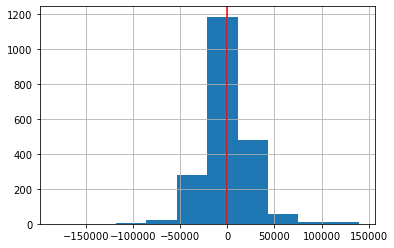

'Your RMSE for test poly1 is 24141.280781900485.'

In [51]:
make_model(home, 'poly1', features, 0)

This polynomial function looks brilliant on the numerical only data, but when I incorporated it into my overall model, it seemed to create a serious overfit, where my model was exceptional but my predictions were 100k off. I'm going to see what it looks like on the test data without any categorical filters.

In [52]:
features = ['overall_qual', 'year_built', 'year_remod/add', 'total_bsmt_sf', 'gr_liv_area', 'full_bath', 'garage_area',
           'mas_vnr_area', 'totrms_abvgrd', 'fireplaces', 'bsmtfin_sf_1']

In [53]:
def save_test(df, test_name, features_list, dum_cols):
    X = df[features_list]
    X['mas_vnr_area'].fillna(X['mas_vnr_area'].mean(), inplace=True) #filling in mean for this column's nans
    X.fillna(0, inplace=True) #fill rest of numerical nans with 0
    #if dum_cols != 0: #if you need to get dummies in any categorical columns, it happens here, otherwise enter '0'
    #X = pd.get_dummies(X, columns=dum_cols, drop_first=True)
    y = df['saleprice'] #add target
    #lr = LinearRegression()
    #lr.fit(X, y)
    poly = PolynomialFeatures(include_bias=False)
    X_poly = poly.fit_transform(X)
    lr = LinearRegression()
    lr.fit(X_poly, y)
    print(f'Your R2 score is {lr.score(X_poly, y)}')
    #print('first done')
    test = pd.read_csv('datasets/test.csv') #read in test file
    test.columns = [col.lower().replace(' ', '_') for col in test.columns] #reformat test columns
    sub = test[['id']].copy() #put id numbers in empty array
    
    #apply categorical column grouping changes to test data
    
    #print('cats done')
    #sub = test[['id']].copy() #put id numbers in empty array
    X_test = test[features_list] #create X value based on selected features
    X_test['mas_vnr_area'].fillna(X_test['mas_vnr_area'].mean(), inplace=True) #filling in mean for this column's nans
    X.fillna(0, inplace=True) #fill rest of numerical nans with 0
    #if dum_cols != 0: #if you need to get dummies in any categorical columns, it happens here, else enter '0'
    #X_test = pd.get_dummies(X_test, columns=dum_cols, drop_first=True)
    #print('X_test made')
    Xt_poly = poly.fit_transform(X_test) #poly transform the x_test list
    sub['SalePrice'] = lr.predict(Xt_poly) #make new df column from predictions
    #print('sub done')
    sub = sub.rename(columns = {'id' : 'Id'}) #rename id column to fit submission model
    sub['Id'] = [int(n) for n in sub['Id']] #make id numbers ints to fit submission model
    #sub['SalePrice'] = [abs(n) for n in sub['SalePrice']]
    print(sub.head())
    query = input('Save data? Please enter "yes" or "no".')
    if query == 'yes':
        sub.to_csv(f'models/mod{test_name}.csv', index=False) #save submission as new csv
        return f"All done, submission {test_name} saved"
    elif query == 'no':
        return 'Better luck next time'
    #return sub.head() #use to preview before saving

In [54]:
save_test(home, 'num_poly', features, 0)

C:\Users\willg\anaconda3\lib\site-packages\pandas\core\generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)
C:\Users\willg\anaconda3\lib\site-packages\pandas\core\frame.py:4147: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(
C:\Users\willg\anaconda3\lib\site-packages\pandas\core\generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)
C:

Your R2 score is 0.9071805544736425
     Id      SalePrice
0  2658  138104.060129
1  2718  156370.888804
2  2414  187105.329038
3  1989  118610.011934
4   625  186564.132298


Save data? Please enter "yes" or "no". no


'Better luck next time'

Okay - that brought me up about 2k on the leaderboard - still 27k which is significantly higher than the training RMSE which was in the 24k range. I need to try some other methods besides polynomial.

In [55]:
#https://stackoverflow.com/questions/52590745/what-is-the-inverse-operation-of-np-log-and-np-diff

In [56]:
#accepts df name, test_name, features list, any feature columns that need to be dummified
def make_model(df, test_name, features, dum_cols):
    X = df[features] #will make nan (should only be numerical) values zeroes
    X['mas_vnr_area'].fillna(df['mas_vnr_area'].mean(), inplace=True)
    X.fillna(0, inplace=True)
    if dum_cols != 0: #if you need to get dummies in any categorical columns, it happens here, otherwise enter '0'
        X = pd.get_dummies(X, columns=dum_cols, drop_first=True)
    y = df['saleprice'].map(np.log) #add target
    
    lr = LinearRegression() #this section for regular linear regression
    lr.fit(X, y)
    
    #poly = PolynomialFeatures(include_bias=False) #this section for polynomnial regression
    #X_poly = poly.fit_transform(X)
    #lr = LinearRegression()
    #lr.fit(X_poly, y)
    
    #y = np.exp(y)
    
    print(f'Your R2 score is {lr.score(X, y)}')
    pred = lr.predict(X) #change this variable if you change to polynomial
    
    #pred = [n*1 for n in pred] #manual adjustment of preds if desired
    residuals = np.exp(y) - np.exp(pred) #these are the residuals
    residuals.hist()
    plt.axvline(0, color = 'red')
    plt.show()
    return f'Your RMSE for test {test_name} is {metrics.mean_squared_error(y, pred)**.5}.'

In [57]:
features = ['overall_qual', 'year_built', 'year_remod/add', 'total_bsmt_sf', 'gr_liv_area', 'full_bath', 'garage_area',
           'mas_vnr_area', 'totrms_abvgrd', 'fireplaces', 'bsmtfin_sf_1']

C:\Users\willg\anaconda3\lib\site-packages\pandas\core\generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)
C:\Users\willg\anaconda3\lib\site-packages\pandas\core\frame.py:4147: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


Your R2 score is 0.8347151686163203


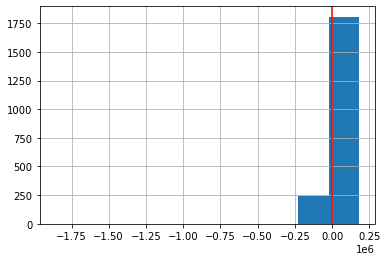

'Your RMSE for test log1 is 0.1671808938701029.'

In [58]:
make_model(home, 'log1', features, 0)

The log method brought my kaggle score down about 5k! I'd like to add a standard scalar and see how that performs - with the log making it a normal distribution, it might work.

In [59]:
#ss learned from lesson 3.05

In [110]:
#accepts df name, test_name, features list, any feature columns that need to be dummified
def make_model(df, test_name, features, dum_cols):
    X = df[features] #will make nan (should only be numerical) values zeroes
    X['mas_vnr_area'].fillna(df['mas_vnr_area'].mean(), inplace=True)
    X.fillna(0, inplace=True)
    if dum_cols != 0: #if you need to get dummies in any categorical columns, it happens here, otherwise enter '0'
        X = pd.get_dummies(X, columns=dum_cols, drop_first=True)
    y = df['saleprice'].map(np.log) #add target
    
    ss= StandardScaler()#this code for using a standard scalar on x
    ss.fit(X)
    X_scaled = ss.transform(X)
    
    lr = LinearRegression() #this section for regular linear regression
    lr.fit(X_scaled, y)
       
    #poly = PolynomialFeatures(include_bias=False) #this section for polynomnial regression
    #X_poly = poly.fit_transform(X)
    #lr = LinearRegression()
    #lr.fit(X_poly, y)
    
    #y = np.exp(y)
    
    print(f'Your R2 score is {lr.score(X_scaled, y)}')
    pred = lr.predict(X_scaled) #change this variable if you change to polynomial
    
    #pred = [n*1 for n in pred] #manual adjustment of preds if desired
    residuals = np.exp(y) - np.exp(pred) #these are the residuals
    residuals.hist()
    plt.axvline(0, color = 'red')
    plt.show()
    return f'Your RMSE for test {test_name} is {metrics.mean_squared_error(y, pred)**.5}.'

In [61]:
features = ['overall_qual', 'year_built', 'year_remod/add', 'total_bsmt_sf', 'gr_liv_area', 'full_bath', 'garage_area',
           'mas_vnr_area', 'totrms_abvgrd', 'fireplaces', 'bsmtfin_sf_1']

C:\Users\willg\anaconda3\lib\site-packages\pandas\core\generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)
C:\Users\willg\anaconda3\lib\site-packages\pandas\core\frame.py:4147: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


Your R2 score is 0.8347151686163203


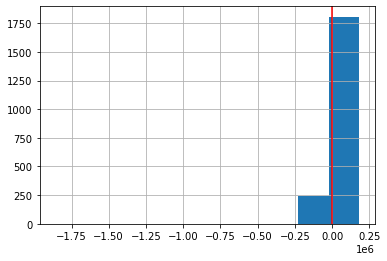

'Your RMSE for test sslog1 is 0.16718089387010293.'

In [62]:
make_model(home, 'sslog1', features, 0)

This was a test with the log method plus ss transformation on x. It scored about the same as the log method alone so not a real benefit there.

In [63]:
features = ['overall_qual', 'year_remod/add', 'total_bsmt_sf', 'gr_liv_area', 'full_bath', 'garage_area',
           'mas_vnr_area', 'totrms_abvgrd', 'fireplaces', 'bsmtfin_sf_1']

C:\Users\willg\anaconda3\lib\site-packages\pandas\core\generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)
C:\Users\willg\anaconda3\lib\site-packages\pandas\core\frame.py:4147: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


Your R2 score is 0.826348865857305


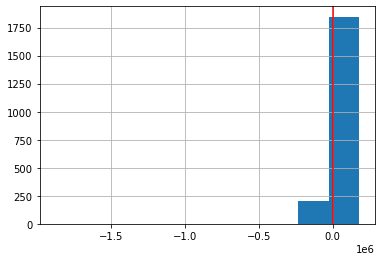

'Your RMSE for test sslog1 is 0.17135980349604527.'

In [64]:
make_model(home, 'sslog1', features, 0)

This was a test with the normal log method but I removed the year built category. My RMSE went down about .01 so it's fair to assume that column was useful. I'll try it again without the remod column instead and see how that works.

In [65]:
features = ['overall_qual', 'year_built', 'total_bsmt_sf', 'gr_liv_area', 'full_bath', 'garage_area',
           'mas_vnr_area', 'totrms_abvgrd', 'fireplaces', 'bsmtfin_sf_1']

C:\Users\willg\anaconda3\lib\site-packages\pandas\core\generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)
C:\Users\willg\anaconda3\lib\site-packages\pandas\core\frame.py:4147: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


Your R2 score is 0.8263168163072707


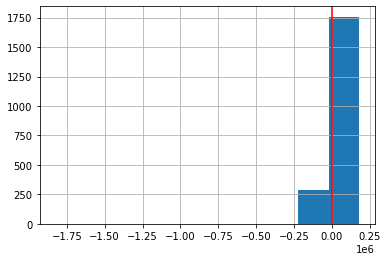

'Your RMSE for test sslog1 is 0.17137561609422236.'

In [66]:
make_model(home, 'sslog1', features, 0)

I'm going to try engineering a few numerical features and see if they help at all. Returning to my heatmap...

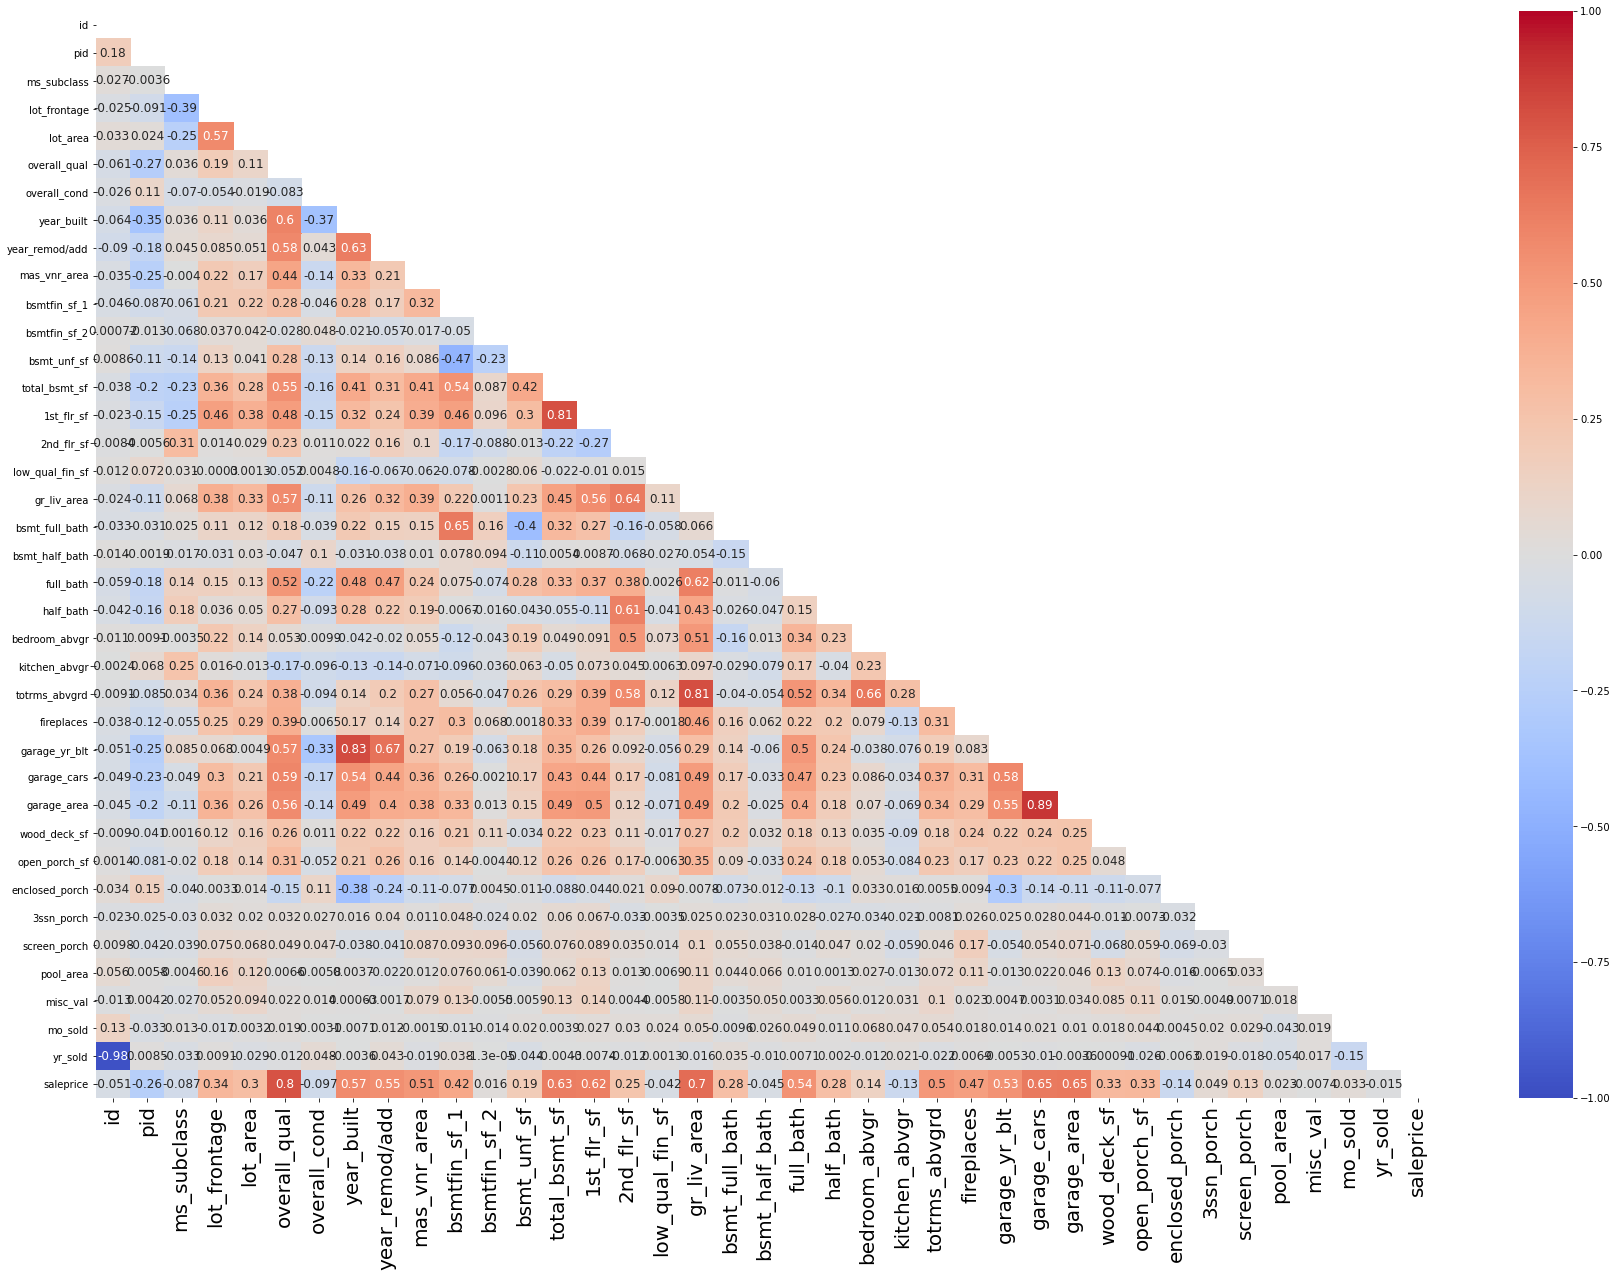

In [67]:
corr = home.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.figure(figsize=(30,20))
#plt.yticks(size=20)
plt.xticks(size=20, rotation=15)
sns.heatmap(home.corr(), mask=mask, annot=True, cmap='coolwarm', vmin=-1, vmax=1, annot_kws={"size":12});

A couple ideas: my most correlated are overall_qual and gr_liv_area, maybe I should try multiplying them:

In [68]:
home['oqual_gla'] = home['overall_qual']*home['gr_liv_area']

I took out garage cars because it was so close to garage area, maybe I'll try putting it in?

In [85]:
home['garage'] = home['garage_cars']*home['garage_area']

How about a living area metric that is total_bsmnt_sf * 1st_flr_sf * gr_liv_area?

In [88]:
home['liv_tot'] = home['total_bsmt_sf']*home['1st_flr_sf']*home['gr_liv_area']

Let's see if we got any hits?

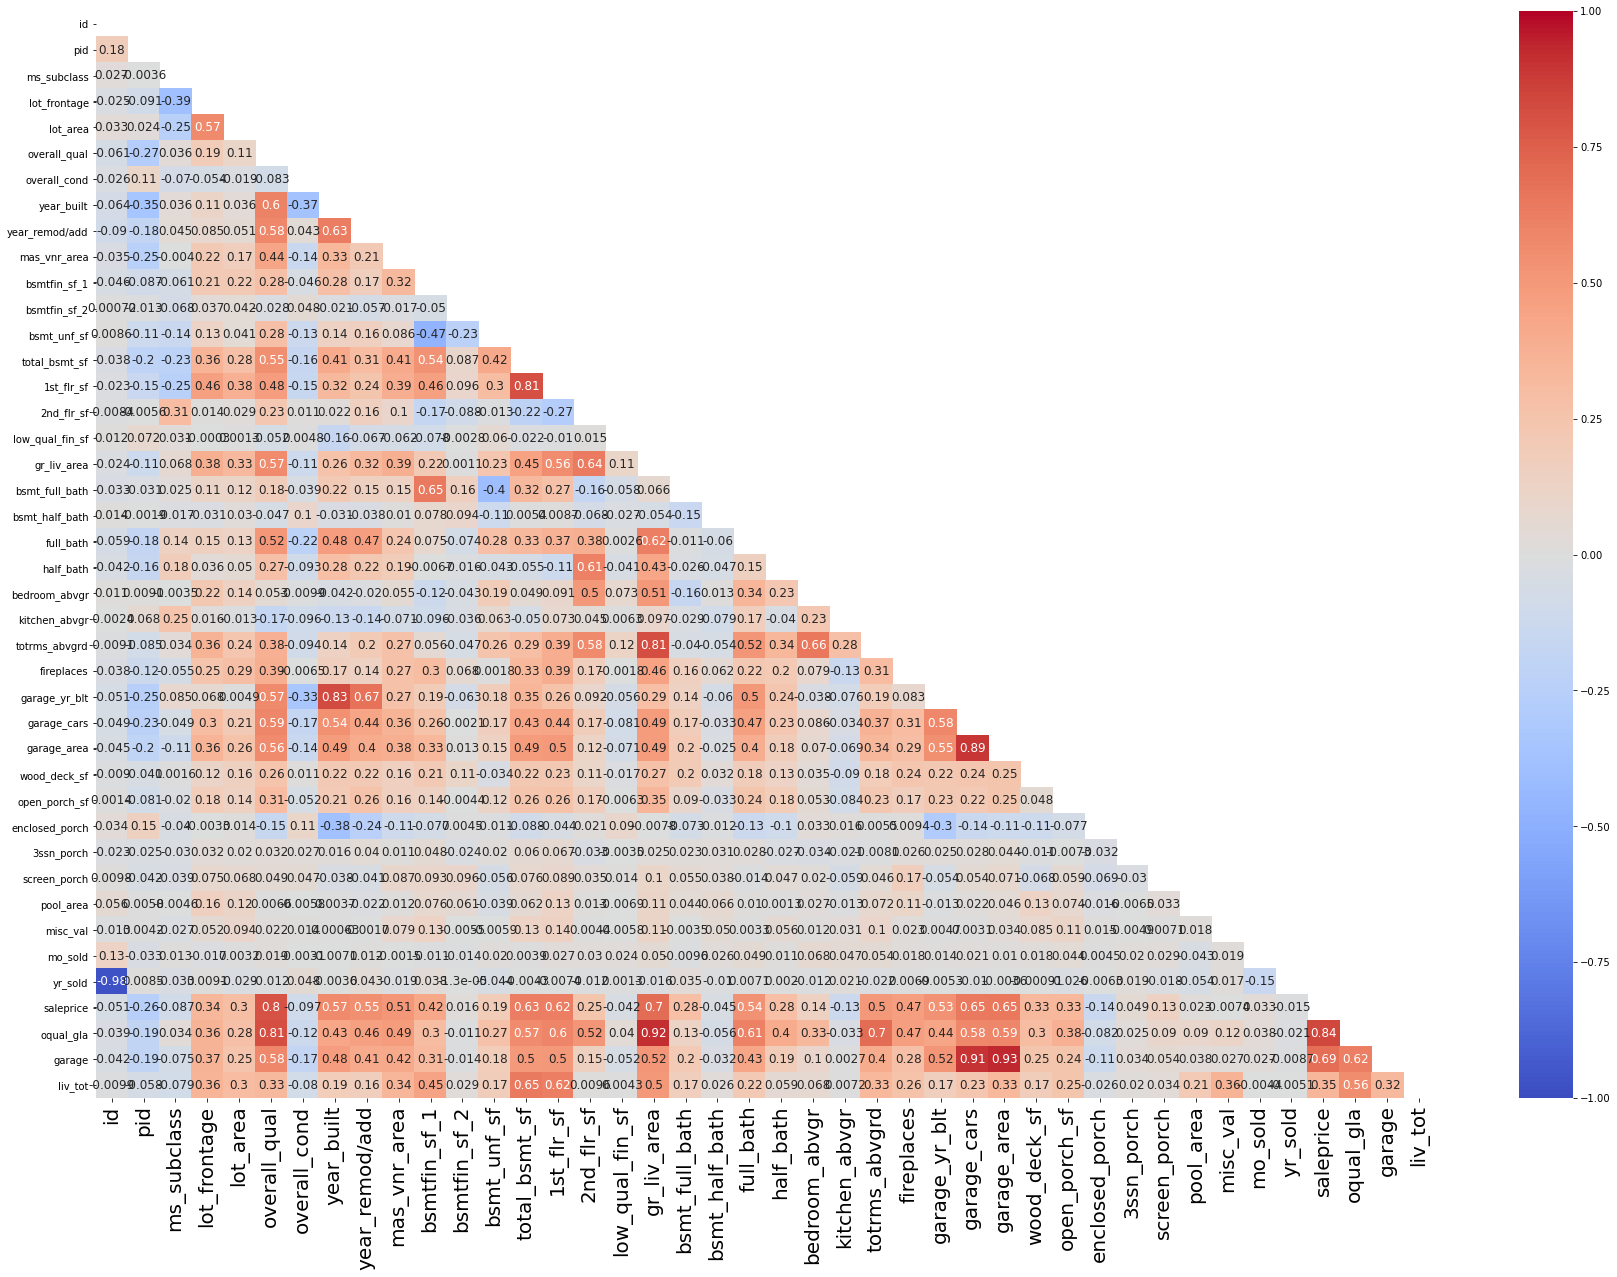

In [89]:
corr = home.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.figure(figsize=(30,20))
#plt.yticks(size=20)
plt.xticks(size=20, rotation=15)
sns.heatmap(home.corr(), mask=mask, annot=True, cmap='coolwarm', vmin=-1, vmax=1, annot_kws={"size":12});

My new "garage" feature is .69 correlated, which is better than either of those features on their own. My new "oqual_gla" feature is .84 correlated to sale price which beats either of those individually.

In [90]:
features = ['year_built', 'total_bsmt_sf', 'full_bath', 'mas_vnr_area', 'totrms_abvgrd', 'fireplaces', 'bsmtfin_sf_1', 'oqual_gla', 'garage']

C:\Users\willg\anaconda3\lib\site-packages\pandas\core\generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)
C:\Users\willg\anaconda3\lib\site-packages\pandas\core\frame.py:4147: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


Your R2 score is 0.7882185783857866


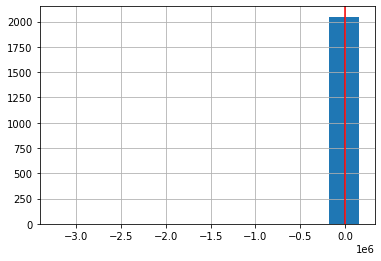

'Your RMSE for test oqual_gla_test is 0.189240493984571.'

In [91]:
make_model(home, 'oqual_gla_test', features, 0)

This combined feature list scores worse than the prior list. Let's remind ourselves what score we had without any multiplied features.

In [92]:
features = ['overall_qual', 'year_built', 'total_bsmt_sf', 'gr_liv_area', 'full_bath', 'garage_area',
           'mas_vnr_area', 'totrms_abvgrd', 'fireplaces', 'bsmtfin_sf_1']

C:\Users\willg\anaconda3\lib\site-packages\pandas\core\generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)
C:\Users\willg\anaconda3\lib\site-packages\pandas\core\frame.py:4147: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


Your R2 score is 0.8263168163072707


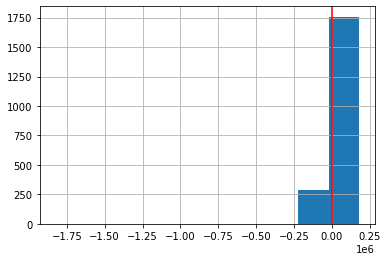

'Your RMSE for test orig_feats is 0.17137561609422236.'

In [93]:
make_model(home, 'orig_feats', features, 0)

Now if I *add* those 2 new categories *without* removing what created them, does that help?

In [97]:
features = ['overall_qual', 'year_built', 'total_bsmt_sf', 'gr_liv_area', 'full_bath', 'garage_area',
           'mas_vnr_area', 'totrms_abvgrd', 'fireplaces', 'bsmtfin_sf_1', 'oqual_gla', 'garage', 'liv_tot']

C:\Users\willg\anaconda3\lib\site-packages\pandas\core\generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)
C:\Users\willg\anaconda3\lib\site-packages\pandas\core\frame.py:4147: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


Your R2 score is 0.8627124301240399


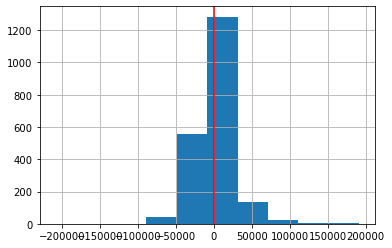

'Your RMSE for test old_and_newfeats is 0.15236518813185.'

In [98]:
make_model(home, 'old_and_newfeats', features, 0)

It appears to help! I'll try this in my overall model.

...some time later...

I'm not making much headway on the categorical variables. I'm going to throw in some more numericals and see if it helps on this side.  
I didn't use these 3 in my earlier model but they're above .3 in correlation on my heatmap, lets see how we do with them.  
- lot_frontage
- lot_area
- wood_deck_sf
- open_porch_sf

C:\Users\willg\anaconda3\lib\site-packages\pandas\core\generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)
C:\Users\willg\anaconda3\lib\site-packages\pandas\core\frame.py:4147: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


Your R2 score is 0.8689456180416824


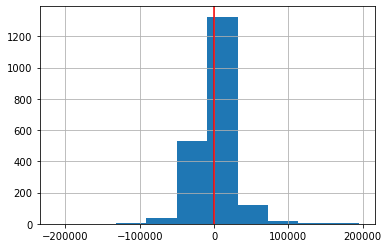

'Your RMSE for test old_and_newfeats is 0.14886613630048837.'

In [111]:
features = ['overall_qual', 'year_built', 'total_bsmt_sf', 'gr_liv_area', 'full_bath', 'garage_area',
           'mas_vnr_area', 'totrms_abvgrd', 'fireplaces', 'bsmtfin_sf_1', 'oqual_gla', 'garage', 'liv_tot',
           'lot_frontage', 'lot_area', 'wood_deck_sf', 'open_porch_sf']
make_model(home, 'old_and_newfeats', features, 0)

Okay, that brought it down from before. I'm going to put those 4 into my full model and see if it helps.

In [108]:
home.loc[home['lot_frontage'].isnull()]

,id,pid,ms_subclass,ms_zoning,lot_frontage,lot_area,street,alley,lot_shape,land_contour,...,fence,misc_feature,misc_val,mo_sold,yr_sold,sale_type,saleprice,oqual_gla,garage,liv_tot
0,109,533352170,60,RL,NaN,13517,Pave,NaN,IR1,Lvl,...,NaN,NaN,0,3,2010,WD,130500,8874,950.0,7.773994e+08
7,145,535154050,20,RL,NaN,12160,Pave,NaN,IR1,Lvl,...,MnPrv,NaN,0,5,2010,COD,142000,5940,1062.0,1.676677e+09
8,1942,535353130,20,RL,NaN,15783,Pave,NaN,Reg,Lvl,...,MnPrv,Shed,400,6,2007,WD,112500,4620,420.0,7.888890e+08
23,12,527165230,20,RL,NaN,7980,Pave,NaN,IR1,Lvl,...,GdPrv,Shed,500,3,2010,WD,185000,7122,840.0,1.645676e+09
27,1534,909277040,50,RL,NaN,11700,Pave,Grvl,IR1,HLS,...,NaN,NaN,0,7,2008,WD,198000,9690,240.0,2.309379e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016,560,532376110,20,RL,NaN,7791,Pave,NaN,IR1,Lvl,...,GdWo,NaN,0,10,2009,WD,129000,4560,300.0,7.585505e+08
2022,2872,909475020,20,RL,NaN,16381,Pave,NaN,IR1,Lvl,...,NaN,NaN,0,12,2006,WD,223000,11064,1080.0,6.270220e+09
2028,2526,534127190,20,RL,NaN,20781,Pave,NaN,IR2,Lvl,...,NaN,NaN,0,6,2006,WD,262500,15092,1016.0,7.288591e+09
2031,25,527402250,20,RL,NaN,12537,Pave,NaN,IR1,Lvl,...,NaN,NaN,0,4,2010,WD,149900,5390,1000.0,1.252727e+09
